# Optical Character Recognition (OCR) Data Entry Use Case

By: Jeevaka Kiriella

Analyst spend time manually entering data into a spreadsheet or table for analysis.  An analyst can get help with a Roots Automation Bot to combine data from invoices into a dataframe for human analysis. 

For this use case I've developed a data entry pipeline that leverages OCR.
The flow of the pipeline is PDF Ingestion --> JPG --> Text Extraction --> dataframe

Pain point: Lost time due to data entry.

Solution: OCR to move invoice data into a tabular format. 

In [51]:
import pdf2image
try:
    from PIL import Image as IMG
except ImportError:
    import Image as IMG
import pytesseract
import numpy as np
import cv2
import code
import pandas as pd
import csv
from IPython.display import Image

In [63]:
class pre_process_pdfs(object):
    '''Class of function to convert pdfs to images'''
    def __init__(*args, **kwargs):
        self.image = None
    
    @classmethod
    def pdf_to_img(cls, pdf_file, *args, **kwargs):
        return pdf2image.convert_from_path(pdf_file, 500)

    @classmethod
    def save_pdf_img(cls, pdf_image, *args, **kwargs):
        images = cls.pdf_to_img(pdf_image)
        for page in images:
            page.save('test_invoice.jpg', 'JPEG')


class proc_images(object):
    '''Class of functions to process images'''
    def __init__(self, *args, **kwargs):
        self.path = None #set path to images
    
    @classmethod
    def read_images(cls, filename, *args, **kwargs):
        return cv2.imread('test_invoice.jpg')

    @classmethod
    def ocr(cls, data, *args, **kwargs):
        custom_config = r'--oem 3 --psm 6'
        text = pytesseract.image_to_string(data, lang = 'eng', config = custom_config)
        return text

    @classmethod
    def qa_doc_write_image_to_file (cls, image_file, *args, **kwargs):
        image = cls.read_images(image_file)
        #write invoice data to txt file.
        try:
            f = open('invoices.txt', 'x')
        except Exception as e:
            f = open('invoices.txt', 'a')
        print(cls.ocr(image))
        f.write(cls.ocr(image))
        f.close()
        return image
    
    @classmethod
    def image_text_to_df(cls, filename, *args, **kwargs):
        return pytesseract.image_to_data(IMG.open(filename), lang = 'eng', output_type = 'data.frame')
    
    @classmethod
    def image_relevant_text_to_dict(cls, filename, *args, **kwargs):
        df = proc_images.image_text_to_df(filename)
        text_field = list(df.get('text').unique())
        invoice_dict = {}
        for idx, items in enumerate(text_field):
            if items == '#':
                invoice_dict['invoice'] = text_field[idx + 1]
            elif items == '—':
                invoice_dict['first_name_from'] = text_field[idx + 1]
            elif items == '—':
                invoice_dict['last_name_from'] = text_field[idx + 2]
            elif items == 'Date:':
                invoice_dict['date_month'] = text_field[idx + 1]
                invoice_dict['date_day'] = text_field[idx + 2].strip(',')
                invoice_dict['date_year'] = text_field[idx + 3]
            elif items == 'To:':
                invoice_dict['client'] = text_field[idx + 2] + " " + text_field[idx + 3]
            elif items == 'Due:':
                invoice_dict['amount_due'] = text_field[idx + 1]        
        return invoice_dict
    
    @classmethod
    def invoice_dict_to_df(cls, invoice_dict, *args, **kwargs):
        return pd.DataFrame([invoice_dict], columns = invoice_dict.keys())
        

### Image used for extraction

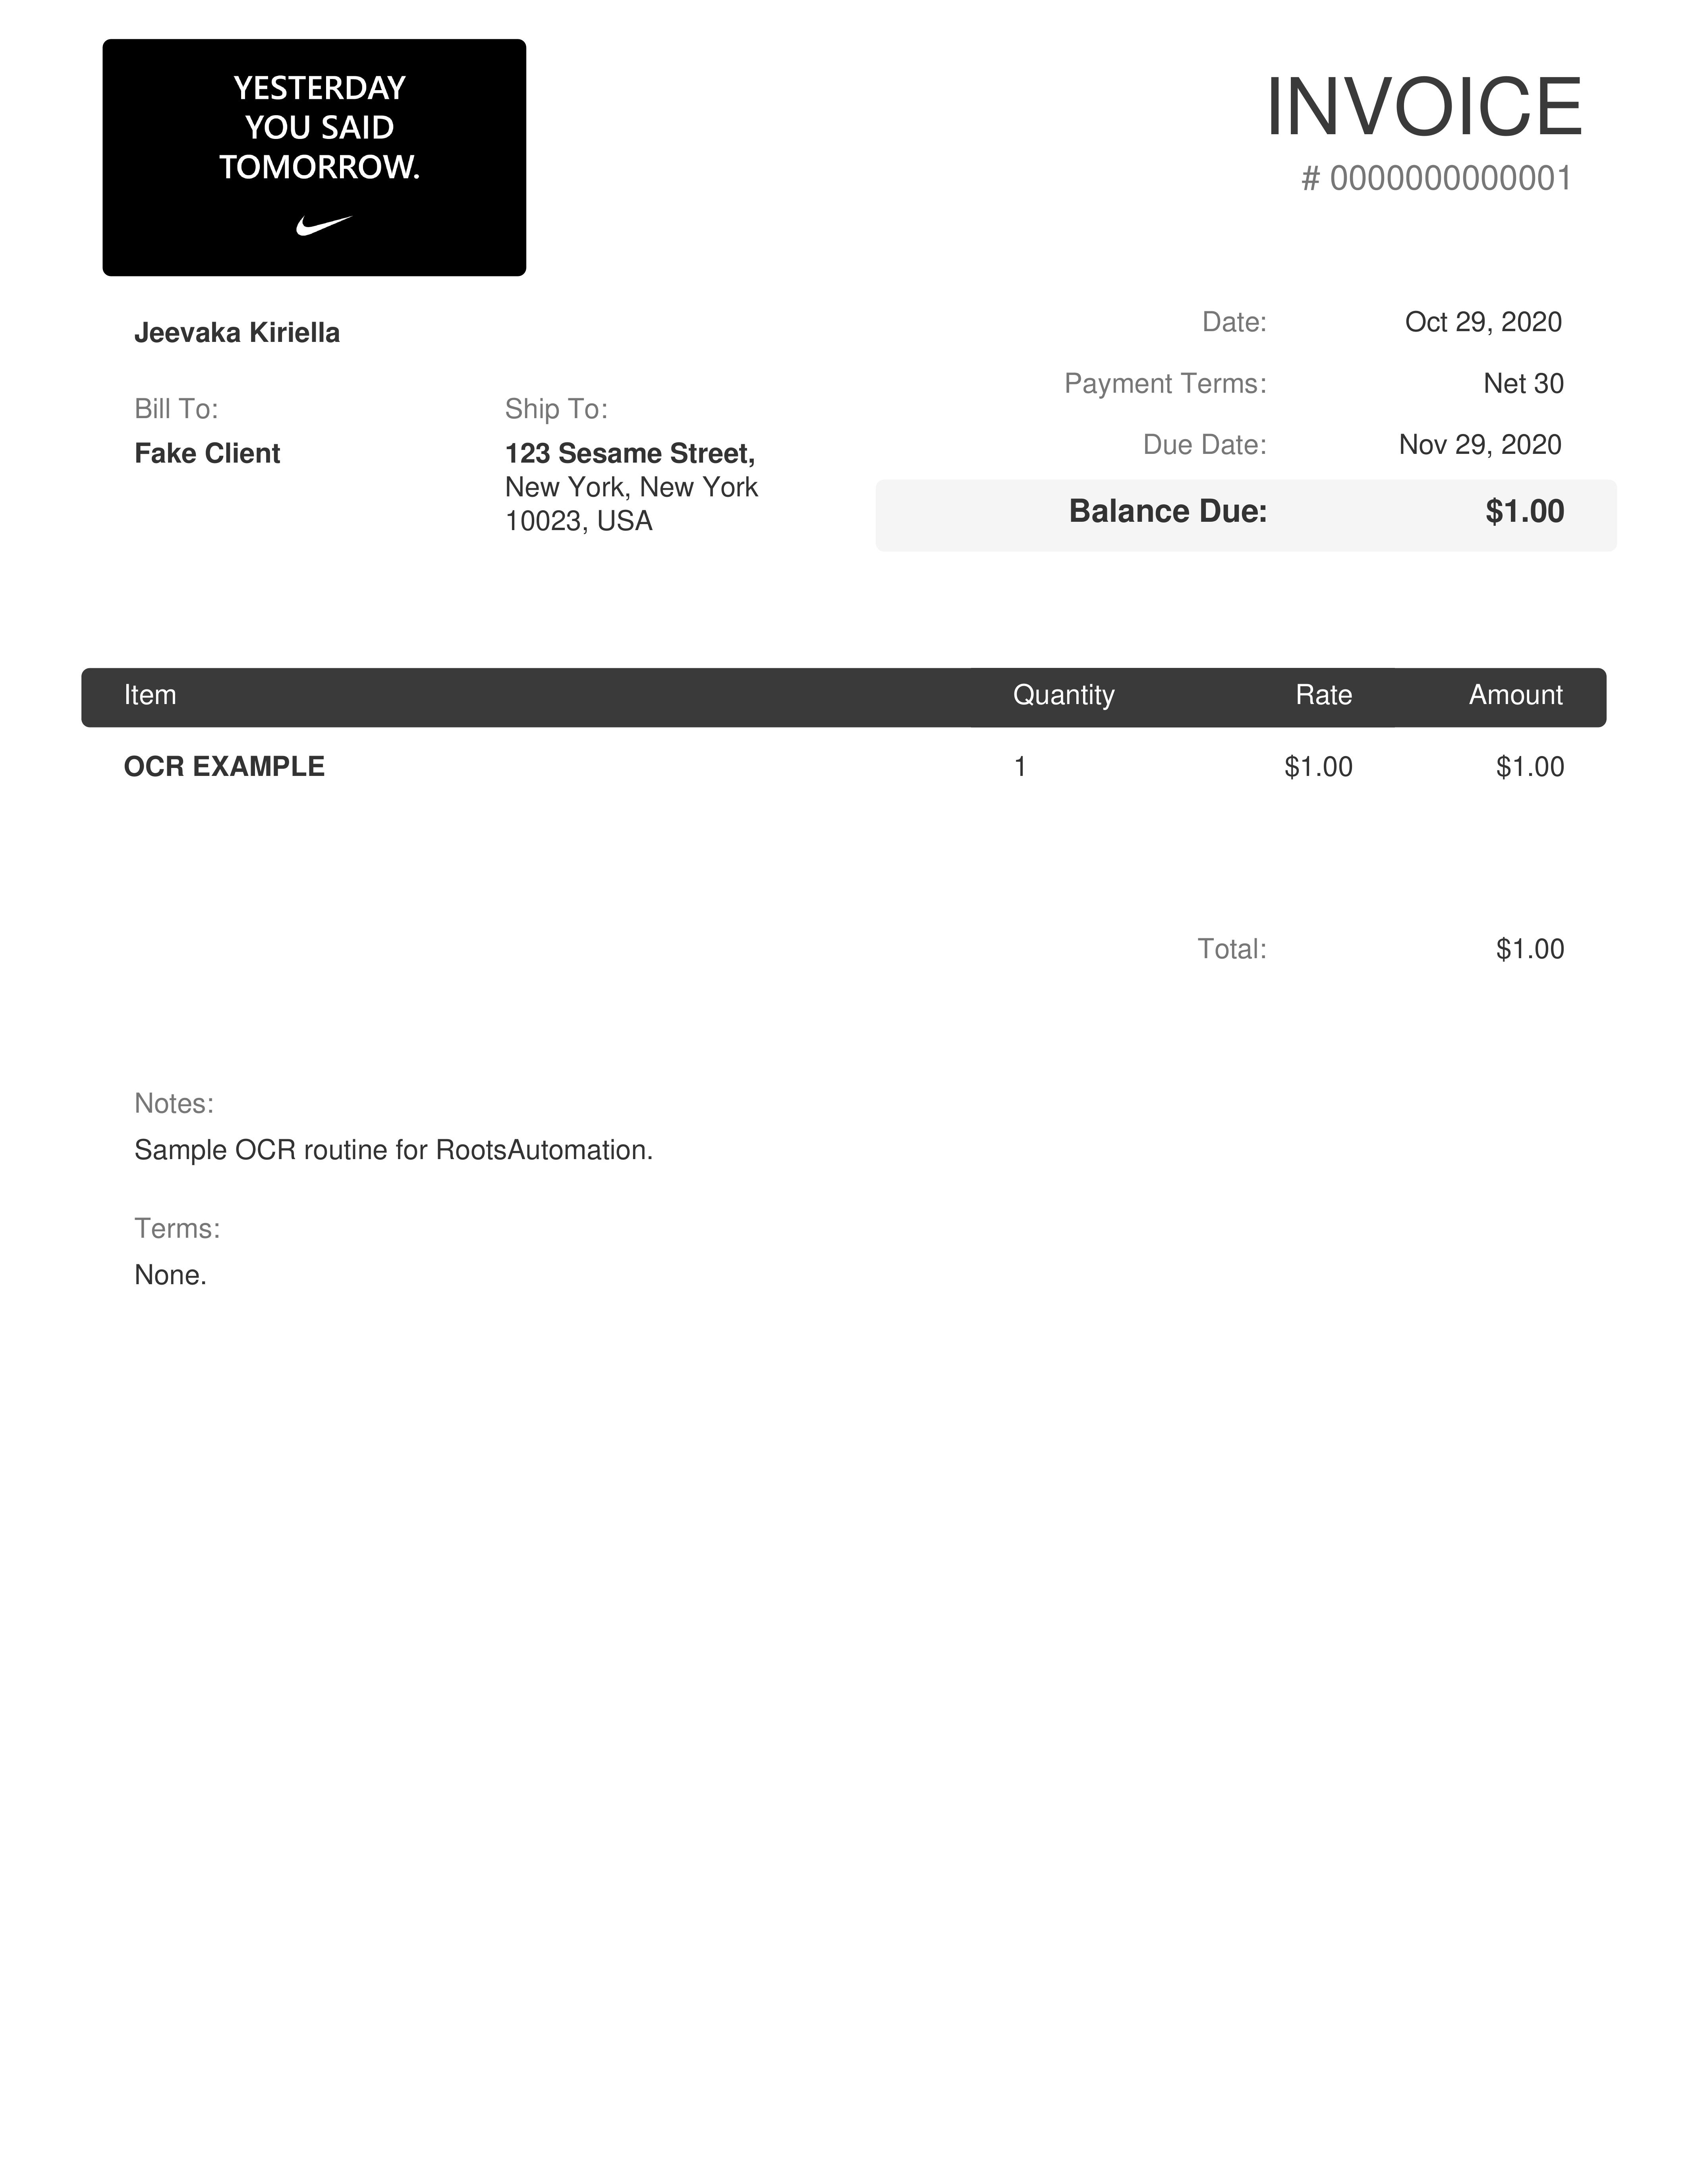

In [45]:
pre_process_pdfs.save_pdf_img('test_invoice.pdf')
Image(filename = 'test_invoice.jpg')

### Sample output from extracting text

The data comes in very unstructured. The goal here is to extract information relevant for data entry.

In [48]:
img = proc_images.ocr(proc_images.read_images('test_invoice.jpg'))
print(img)

wry INVOICE
YOU SAID
ee ele # 0000000000001
| >
Jeevaka Kiriella Date: Oct 29, 2020
Payment Terms: Net 30
Bill To: Ship To:
Fake Client 123 Sesame Street, Due Date: Nov 29, 2020
New York, New York
10023, USA Balance Due: $1.00
ltem Quantity tells) Amount
OCR EXAMPLE 1 $1.00 $1.00
Total: $1.00
Notes:
Sample OCR routine for RootsAutomation.
Terms:
None.



In [9]:
#input bound box data into a dictionary
from pytesseract import Output
d = pytesseract.image_to_data(proc_images.read_images('test_invoice.jpg'), output_type = Output.DICT)

#input bound box data into dataframe
df = pytesseract.image_to_data(Image.open('test_invoice.jpg'), lang = 'eng', output_type = 'data.frame')
df.get('text').unique()

array([nan, 'cote', 'INVOICE', ' ', 'TOMORROW.', '#', '0000000000001',
       '—', 'Jeevaka', 'Kiriella', 'Date:', 'Oct', '29,', '2020',
       'Payment', 'Terms:', 'Net', '30', 'Bill', 'To:', 'Ship', 'Fake',
       'Client', '123', 'Sesame', 'Street,', 'Due', 'Nov', 'New', 'York,',
       'York', '10023,', 'USA', 'Balance', 'Due:', '$1.00', 'iccTan',
       'ele', 'Taiiyg', 'Rate', 'Amount', 'OCR', 'EXAMPLE', '1', 'Total:',
       'Notes:', 'Sample', 'routine', 'for', 'RootsAutomation.', 'None.'],
      dtype=object)

From the above we can see that taking unique information from the 'text' field can relay specific information like invoice number, date, address, balance due. 

Important to note that the sequence of the field 'text' is important for extracting relevant information

### Final output calling the proc_images class

In [64]:
invoice_dict = proc_images.image_relevant_text_to_dict('test_invoice.jpg')
df = proc_images.invoice_dict_to_df(invoice_dict)
df.head()

,invoice,date_month,date_day,date_year,client,amount_due
0,0000000000001,Oct,29,2020,Fake Client,$1.00
